Install Necessary Packages

In [1]:
!pip install torch torchvision scikit-learn matplotlib seaborn scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.stats import ks_2samp, entropy
import seaborn as sns

Load MNIST Dataset

In [3]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 54.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.73MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.28MB/s]


Define VAE Architecture

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # Mean
        self.fc22 = nn.Linear(400, latent_dim)  # Log-variance
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)  # mu, log_var

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


ELBO (evidence lower bound) Loss Function with KL-Divergence

In [5]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

Train the VAE

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch, _ in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(batch)
        loss, bce, kld = loss_function(recon, batch, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader.dataset):.4f}")


Epoch 1, Loss: 190.2187
Epoch 2, Loss: 166.9564
Epoch 3, Loss: 162.7824
Epoch 4, Loss: 160.5309
Epoch 5, Loss: 158.8598
Epoch 6, Loss: 157.6363
Epoch 7, Loss: 156.6340
Epoch 8, Loss: 155.7666
Epoch 9, Loss: 155.0718
Epoch 10, Loss: 154.4530


Visualize the Latent Space

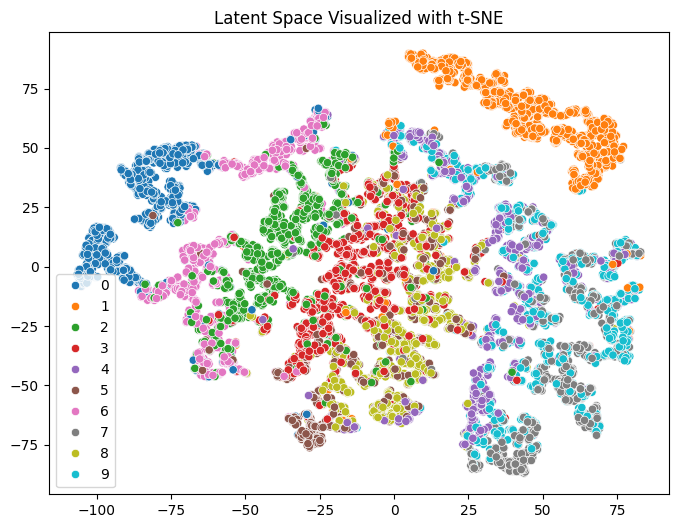

In [7]:
model.eval()
latents, labels = [], []

with torch.no_grad():
    for batch, label in test_loader:
        batch = batch.to(device)
        _, mu, _ = model(batch)
        latents.append(mu.cpu().numpy())
        labels.append(label.numpy())

latents = np.concatenate(latents)
labels = np.concatenate(labels)

tsne = TSNE(n_components=2, perplexity=30)
z_tsne = tsne.fit_transform(latents)

plt.figure(figsize=(8,6))
sns.scatterplot(x=z_tsne[:,0], y=z_tsne[:,1], hue=labels, palette="tab10", legend="full")
plt.title("Latent Space Visualized with t-SNE")
plt.show()

Interpolate in Latent Space

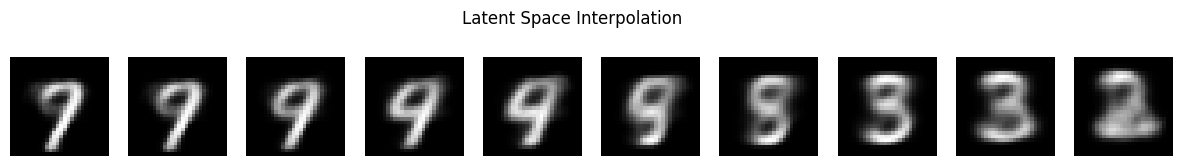

In [8]:
def interpolate(start, end, steps=10):
    vectors = []
    for alpha in np.linspace(0, 1, steps):
        vectors.append((1 - alpha) * start + alpha * end)
    return torch.tensor(np.stack(vectors)).float()

model.eval()
with torch.no_grad():
    # Choose 2 random digits
    batch, _ = next(iter(test_loader))
    x1, x2 = batch[0].to(device), batch[1].to(device)
    mu1, _ = model.encode(x1.view(-1, 28*28))
    mu2, _ = model.encode(x2.view(-1, 28*28))
    z_interp = interpolate(mu1.cpu().numpy(), mu2.cpu().numpy(), 10).to(device)
    reconstructions = model.decode(z_interp).cpu().view(-1, 1, 28, 28)

fig, axes = plt.subplots(1, 10, figsize=(15,2))
for ax, img in zip(axes, reconstructions):
    ax.imshow(img.squeeze(), cmap='gray')
    ax.axis('off')
plt.suptitle("Latent Space Interpolation")
plt.show()


Statistical Testing: Generated vs Real Samples

In [9]:
from scipy.stats import wasserstein_distance

def sample_real_images(n=1000):
    real_imgs = []
    for x, _ in test_loader:
        real_imgs.append(x.view(-1, 28*28))
        if len(real_imgs) * 128 >= n: break
    return torch.cat(real_imgs)[:n]

def sample_generated_images(n=1000):
    with torch.no_grad():
        z = torch.randn(n, 2).to(device)
        generated = model.decode(z).cpu()
    return generated

real_samples = sample_real_images().numpy()
gen_samples = sample_generated_images().numpy()

ks_stat, ks_p = ks_2samp(real_samples.flatten(), gen_samples.flatten())
wass_dist = wasserstein_distance(real_samples.flatten(), gen_samples.flatten())

print(f"KS Test: Statistic={ks_stat:.4f}, p-value={ks_p:.4e}")
print(f"Wasserstein Distance: {wass_dist:.4f}")


KS Test: Statistic=0.8184, p-value=0.0000e+00
Wasserstein Distance: 0.0733
